# Pre-Training
Time2SenCrop


In [ ]:
# Required Packages/Libraries
!pip install peft transformers accelerate

In [ ]:
#Imports
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime
import shutil
import zipfile
from google.colab import drive
from google.colab import files
import csv

In [1]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/linlei1214/SITS-BERT.git

In [ ]:
# Make Required folders in Drive

# Define the base path in your Google Drive
base_path = '/content/drive/MyDrive/checkpoints'

# Define the subfolders  inside 'checkpoints'
subfolders = [
    'pretrain',
    'finetune',
    'finetune_LoRA',
    'finetune_LoRA_time',
    'finetune_LoRA_Time_CL',
    'finetune_time',
    'finetune_Time_CL'
]

# Create each folder
for subfolder in subfolders:
    full_path = os.path.join(base_path, subfolder)
    os.makedirs(full_path, exist_ok=True)

print("All folders created successfully inside /MyDrive/checkpoints")


In [ ]:
# Loading Dataset(Time2SenCrop)
# Replace with actual ZIP file path if different
zip_path = '/content/drive/MyDrive/TimeSen2Crop.zip'
local_zip_path = '/content/TimeSen2Crop.zip'

shutil.copy(zip_path, local_zip_path)

'/content/TimeSen2Crop.zip'

In [ ]:
# Unzip in Colab For Faster I/O
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/TimeSen2Crop')

**Time2Sen Data Extraction for Pretraining(Without Label)**

In [ ]:
# Step 5: Set path to the area you want to process
area_path = '/content/TimeSen2Crop/TimeSen2Crop/32TPT'
dates_file = os.path.join(area_path, 'dates.csv')

# Load Julian dates
dates_file = os.path.join(area_path, 'dates.csv')
julian_dates = pd.read_csv(dates_file, skiprows=1, header=None).squeeze().tolist()

In [ ]:
print(julian_dates[:5])  # Should NOT contain 'acquisition_date' as string

[20170904, 20171014, 20171019, 20171024, 20171103]


In [ ]:
def convert_to_doy(date_int):
    date_str = str(date_int)
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    return date_obj.timetuple().tm_yday

output_rows = []

for class_id in range(16):
    class_folder = os.path.join(area_path, str(class_id))
    print(f"🔍 Checking class folder: {class_folder}")

    if not os.path.exists(class_folder):
        print(f"❌ Folder not found: {class_folder}")
        continue

    pixel_csvs = [f for f in os.listdir(class_folder) if f.endswith('.csv')]
    print(f"📂 Found {len(pixel_csvs)} CSVs in class {class_id}")

    for csv_file in tqdm(pixel_csvs, desc=f"Processing class {class_id}"):
        pixel_path = os.path.join(class_folder, csv_file)

        try:
            df = pd.read_csv(pixel_path)
        except Exception as e:
            print(f"⚠️ Error reading {csv_file}: {e}")
            continue

        # ✅ Check for exactly 10 columns: 9 bands + flag
        if df.shape[1] != 10:
            print(f"⚠️ Skipping {csv_file}: Expected 10 columns, got {df.shape}")
            continue

        if df.shape[0] == 0:
            print(f"⚠️ Skipping {csv_file}: No data rows")
            continue

        N = df.shape[0]  # number of time steps

        # Flatten all 10 columns (including flag) column-wise
        flat_values = []
        for col in df.columns:
            flat_values.extend(df[col].tolist())

        # Add first N Julian dates converted to day-of-year
        if N > len(julian_dates):
            print(f"⚠️ Skipping {csv_file}: Not enough Julian dates for {N} time steps")
            continue

        raw_dates = julian_dates[:N]
        # Convert each date to day-of-year integer
        doy_dates = [convert_to_doy(int(d)) for d in raw_dates]

        # Combine everything
        row = flat_values + doy_dates
        output_rows.append(row)

# Save the final CSV
output_df = pd.DataFrame(output_rows)
output_path = '/content/drive/MyDrive/processed_32TPT.csv'
output_df.to_csv(output_path, index=False, header=False)

print(f"✅ Final CSV saved to: {output_path}")
print(f"📈 Total rows written: {len(output_df)}")


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/0
📂 Found 1 CSVs in class 0


Processing class 0: 100%|██████████| 1/1 [00:00<00:00, 207.25it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/1
📂 Found 20001 CSVs in class 1


Processing class 1: 100%|██████████| 20001/20001 [00:40<00:00, 497.30it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/2
📂 Found 1684 CSVs in class 2


Processing class 2: 100%|██████████| 1684/1684 [00:11<00:00, 149.71it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/3
📂 Found 458 CSVs in class 3


Processing class 3: 100%|██████████| 458/458 [00:01<00:00, 390.86it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/4
📂 Found 0 CSVs in class 4


Processing class 4: 0it [00:00, ?it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/5
📂 Found 0 CSVs in class 5


Processing class 5: 0it [00:00, ?it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/6
📂 Found 33 CSVs in class 6


Processing class 6: 100%|██████████| 33/33 [00:00<00:00, 549.81it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/7
📂 Found 0 CSVs in class 7


Processing class 7: 0it [00:00, ?it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/8
📂 Found 52 CSVs in class 8


Processing class 8: 100%|██████████| 52/52 [00:00<00:00, 532.98it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/9
📂 Found 0 CSVs in class 9


Processing class 9: 0it [00:00, ?it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/10
📂 Found 7 CSVs in class 10


Processing class 10: 100%|██████████| 7/7 [00:00<00:00, 429.51it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/11
📂 Found 229 CSVs in class 11


Processing class 11: 100%|██████████| 229/229 [00:00<00:00, 526.57it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/12
📂 Found 47 CSVs in class 12


Processing class 12: 100%|██████████| 47/47 [00:00<00:00, 574.85it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/13
📂 Found 82 CSVs in class 13


Processing class 13: 100%|██████████| 82/82 [00:00<00:00, 543.60it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/14
📂 Found 97 CSVs in class 14


Processing class 14: 100%|██████████| 97/97 [00:00<00:00, 565.71it/s]


🔍 Checking class folder: /content/TimeSen2Crop/TimeSen2Crop/32TPT/15
📂 Found 1841 CSVs in class 15


Processing class 15: 100%|██████████| 1841/1841 [00:03<00:00, 536.74it/s]


✅ Final CSV saved to: /content/drive/MyDrive/processed_32TPT.csv
📈 Total rows written: 24532


In [ ]:
!python /content/SITS-BERT/code/pretraining.py \
    --dataset_path '/content/drive/MyDrive/processed_32TPT.csv' \
    --pretrain_path '/content/drive/MyDrive/checkpoints/pretrain/' \
    --valid_rate 0.03 \
    --max_length 64 \
    --num_features 10 \
    --epochs 5 \
    --batch_size 256 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 1e-4 \
    --warmup_epochs 1 \
    --decay_gamma 0.99 \
    --dropout 0.1 \
    --gradient_clipping 5.0


2025-05-18 00:02:13.232919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747526533.285000   20201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747526533.305192   20201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 00:02:13.378155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loading training and validation data sets...
loading data successful
training samples: 23797, validation samples: 735
Initial

# FineTuning

**Finetuning on California-Labeled using California-Unlabeled**

In [ ]:
!python /content/SITS-BERT/code/finetuning.py \
    --file_path '/content/drive/MyDrive/California-Labeled/California-Labeled/' \
    --pretrain_path '/content/SITS-BERT/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune/' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100\
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 2e-4 \
    --dropout 0.1


2025-05-22 09:34:20.179440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747906460.199845    2906 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747906460.206072    2906 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 09:34:20.226031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loading Data sets...
training samples: 1300, validation samples: 1300, testing samples: 318588
Creating Dataloader...
Initial

**Finetuning on California-Labeled using Time2SenCrop**

In [ ]:
!python /content/SITS-BERT/code/finetuning.py \
    --file_path '/content/drive/MyDrive/California-Labeled/California-Labeled/' \
    --pretrain_path '/content/drive/MyDrive/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune_Time_CL/' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100\
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 2e-4 \
    --dropout 0.1


### ***FineTuning Using Time2SenCrop***

*Pre-Training : 32TPT*

*Finetuning Training Area : 32TQT*

*Finetuning Validate Area : 33 TUN*

*Finetuning Testing.csv Area : 32TNT*

**Data Extraction Script** (Time2SenCrop With Lables)



---



In [ ]:
area_path = '/content/TimeSen2Crop/TimeSen2Crop/32TNT'
dates_file = os.path.join(area_path, 'dates.csv')

In [ ]:
# Load and convert Julian dates to DOY
julian_raw = pd.read_csv(dates_file, skiprows=1, header=None).squeeze().tolist()

def convert_to_doy(date_int):
    date_str = str(date_int)
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    return date_obj.timetuple().tm_yday

julian_dates = [convert_to_doy(d) for d in julian_raw]

In [ ]:
# Output rows
processed_rows = []

# Process class folders (0 to 12 only)
for class_label in range(13):  # from 0 to 12
    class_folder = os.path.join(area_path, str(class_label))

    if not os.path.isdir(class_folder):
        continue

    for pixel_file in os.listdir(class_folder):
        if not pixel_file.endswith('.csv'):
            continue

        file_path = os.path.join(class_folder, pixel_file)
        df = pd.read_csv(file_path)

        # Drop 'Flag' column
        if 'Flag' in df.columns:
            df = df.drop(columns=['Flag'])

        # Number of time steps
        n_obs = len(df)

        # Flatten each band column (B1 to B9)
        flat_bands = []
        for band in df.columns:
            flat_bands.extend(df[band].tolist())

        # Get corresponding Julian dates
        flat_dates = julian_dates[:n_obs]

        # Create full row
        row = flat_bands + flat_dates + [class_label]
        processed_rows.append(row)

In [ ]:
# Save to CSV
# Generate column names
n_time_steps = len(julian_dates)

columns = []

for band in range(1, 10):  # B1 to B9
    columns.extend([f'B{band}_{i+1}' for i in range(n_time_steps)])

columns.extend([f'Date_{i+1}' for i in range(n_time_steps)])
columns.append('Label')

max_len = max(len(r) for r in processed_rows)
for r in processed_rows:
    if len(r) < max_len:
        r.extend([None] * (max_len - len(r)))  # pad missing values

# Save output
output_df = pd.DataFrame(processed_rows)
output_csv_path = '/content/drive/MyDrive/processed_32TNT.csv'
output_df.to_csv(output_csv_path, index=False, header=False)

print(f"✅ Done! Output saved at: {output_csv_path}")

✅ Done! Output saved at: /content/drive/MyDrive/processed_32TNT.csv


Pre-Processing for Successfull Finetuning on Time2SenCrop

---



In [22]:
# Pre-Processing Script

input_file_path = '/content/drive/MyDrive/processed_32TNT.csv'
output_file_path = '/content/drive/MyDrive/Time2SenCrop/Test.csv'
dimension = 10
feature_dim = dimension + 1
pad_value_range = (1, 366)

def pad_row(row, feature_dim, pad_range):
    # Convert strings to float
    data = np.array(list(map(float, row)))

    label = data[-1]
    features = data[:-1]

    length = len(features)
    remainder = length % feature_dim

    if remainder != 0:
        pad_size = feature_dim - remainder
        pad_values = np.random.randint(pad_range[0], pad_range[1] + 1, size=pad_size)
        features = np.concatenate([features, pad_values])

    padded_data = np.append(features, label)
    return padded_data.tolist()

with open(input_file_path, 'r', newline='') as infile, open(output_file_path, 'w', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    for row in reader:
        padded_row = pad_row(row, feature_dim, pad_value_range)
        writer.writerow(padded_row)

print(f"Padding complete. Padded dataset saved to: {output_file_path}")


Padding complete. Padded dataset saved to: /content/drive/MyDrive/Pre-Processed_Validatetttt.csv


In [24]:
!python /content/SITS-BERT/code/finetuning.py \
    --file_path '/content/drive/MyDrive/Time2SenCrop/' \
    --pretrain_path '/content/drive/MyDrive/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune_time/' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100\
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 2e-4 \
    --dropout 0.1


2025-05-22 22:16:54.439512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747952214.460665   22428 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747952214.467148   22428 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 22:16:54.487205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loading Data sets...
training samples: 21607, validation samples: 21072, testing samples: 21292
Creating Dataloader...
Initia

# FineTuning With LoRA

**LoRA Finetuntunine on California-Labeled using California-Unlabeled**

In [ ]:
!python /content/SITS-BERT/code/finetuning_lora.py \
    --file_path '/content/drive/MyDrive/California-Labeled/California-Labeled/' \
    --pretrain_path '/content/SITS-BERT/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune_LoRA/california' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100 \
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 1e-4 \
    --dropout 0.1 \
    --use_lora \
    --lora_rank 16 \
    --lora_alpha 24 \
    --lora_dropout 0.01

2025-05-22 11:49:03.273339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747914543.295874   36771 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747914543.302884   36771 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 11:49:03.323823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
✅ LoRA enabled with rank=16, alpha=24, dropout=0.01
Loading Data sets...
training samples: 1300, validation samples: 1300, te

**LoRA Finetuntunine on California-Labeled using Time2SenCrop**

In [ ]:
!python /content/SITS-BERT/code/finetuning_lora.py \
    --file_path '/content/drive/MyDrive/California-Labeled/California-Labeled/' \
    --pretrain_path '/content/drive/MyDrive/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune_LoRA_Time_CL/' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100 \
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 1e-4 \
    --dropout 0.1 \
    --use_lora \
    --lora_rank 16 \
    --lora_alpha 24 \
    --lora_dropout 0.01

**LoRA Finetuntunine on Time2SenCrop using Time2SenCrop**

In [25]:
!python /content/SITS-BERT/code/finetuning_lora.py \
    --file_path '/content/drive/MyDrive/Time2SenCrop/' \
    --pretrain_path '/content/drive/MyDrive/checkpoints/pretrain/' \
    --finetune_path '/content/drive/MyDrive/checkpoints/finetune_LoRA_time/' \
    --max_length 64 \
    --num_features 10 \
    --num_classes 13 \
    --epochs 100 \
    --batch_size 128 \
    --hidden_size 256 \
    --layers 3 \
    --attn_heads 8 \
    --learning_rate 1e-4 \
    --dropout 0.1 \
    --use_lora \
    --lora_rank 16 \
    --lora_alpha 24 \
    --lora_dropout 0.01

2025-05-22 23:03:17.836137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747954997.856296   34332 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747954997.862591   34332 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 23:03:17.883925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
✅ LoRA enabled with rank=16, alpha=24, dropout=0.01
Loading Data sets...
training samples: 21607, validation samples: 21072, 

#  Visuals

In [27]:
import sys
sys.path.append('/content/SITS-BERT/code')  # add repo code path

import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from model import SBERT
from model.classification_model import SBERTClassification #  classification wrapper
from dataset import FinetuneDataset  #  dataset class

# --- Model Setup ---

num_features = 10
num_classes = 13  # 13 classes
max_length = 64

# Instantiate base SBERT encoder
sbert = SBERT(
    num_features=num_features,
    hidden=256,
    n_layers=3,
    attn_heads=8,
    dropout=0.1
)

# Wrap in classification model
model = SBERTClassification(
    sbert=SBERT(num_features=10, hidden=256, n_layers=3, attn_heads=8, dropout=0.1),
    num_classes=13
).cuda()

checkpoint = torch.load("/content/drive/MyDrive/checkpoints/finetune/checkpoint.tar")
state_dict = checkpoint.get('model_state_dict', checkpoint.get('state_dict', checkpoint))

model.load_state_dict(state_dict)
model.eval()


# --- Data Setup ---

test_file = "/content/drive/MyDrive/California-Labeled/California-Labeled/Test.csv"
test_dataset = FinetuneDataset(test_file, num_features, max_length)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# --- Inference ---

predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['bert_input'].float().cuda()
        masks = batch['bert_mask'].cuda()
        doys = batch['time'].cuda()

        outputs = model(inputs, doys, masks)  # note the order matches classification_model forward(x, doy, mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.append(preds)

predictions = np.concatenate(predictions)
print(f"Total predictions: {len(predictions)}")
print("Unique predicted classes:", np.unique(predictions))

# --- Reshape and Visualize ---

MAP_HEIGHT = 564
MAP_WIDTH = 564  # crop width by 1 from 565 to match data size

terrain_map = predictions[:MAP_HEIGHT * MAP_WIDTH].reshape(MAP_HEIGHT, MAP_WIDTH)
print("Terrain map shape:", terrain_map.shape)

# Colors for your classes
CDL_COLORS = {
    0: [255, 223, 186],    # corn - light orange
    1: [255, 192, 203],    # cotton - pink
    2: [176, 224, 230],    # Winter Wheat - light blue
    3: [152, 251, 152],    # alfalfa - pale green
    4: [255, 99, 71],      # tomatoes - tomato red
    5: [128, 0, 128],      # grapes - purple
    6: [255, 165, 0],      # citrus - orange
    7: [210, 180, 140],    # almonds - tan
    8: [139, 69, 19],      # walnuts - brown
    9: [255, 250, 205],    # pistachios - light yellow
    10: [192, 192, 192],   # developed - gray
    11: [34, 139, 34],     # evergreen forest - forest green
    12: [124, 252, 0],     # grass/pasture - lawn green
}

colored_img = np.zeros((MAP_HEIGHT, MAP_WIDTH, 3), dtype=np.uint8)
for label, color in CDL_COLORS.items():
    colored_img[terrain_map == label] = color

img = Image.fromarray(colored_img)
img.save("/content/terrain_map.png")
print("Terrain map saved at /content/terrain_map.png")


Total predictions: 318588
Unique predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Terrain map shape: (564, 564)
Terrain map saved at /content/terrain_map.png


**Bands**

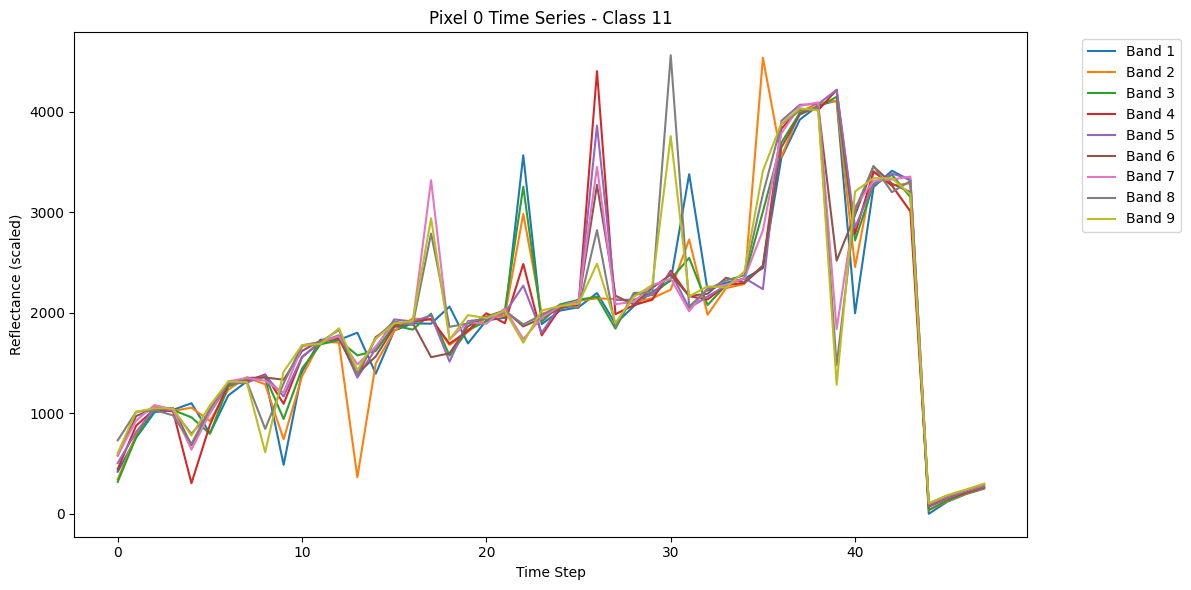

In [29]:
import matplotlib.pyplot as plt
import numpy as np

feat_per_timestep = 10  # 9 bands + 1 DOY

with open('/content/drive/MyDrive/California-Labeled/California-Labeled/Test.csv') as f:
    first_line = f.readline().strip()

vals = list(map(float, first_line.split(',')))
class_label = vals[-1]  # last value is class label

data_vals = vals[:-1]
valid_len = (len(data_vals) // feat_per_timestep) * feat_per_timestep
data_vals = data_vals[:valid_len]

ts = np.array(data_vals).reshape(-1, feat_per_timestep)

# Plot bands 1 to 9
plt.figure(figsize=(12, 6))
for i in range(9):
    plt.plot(ts[:, i], label=f'Band {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Reflectance (scaled)')
plt.title(f'Pixel 0 Time Series - Class {int(class_label)}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




**Class Distribution chart**

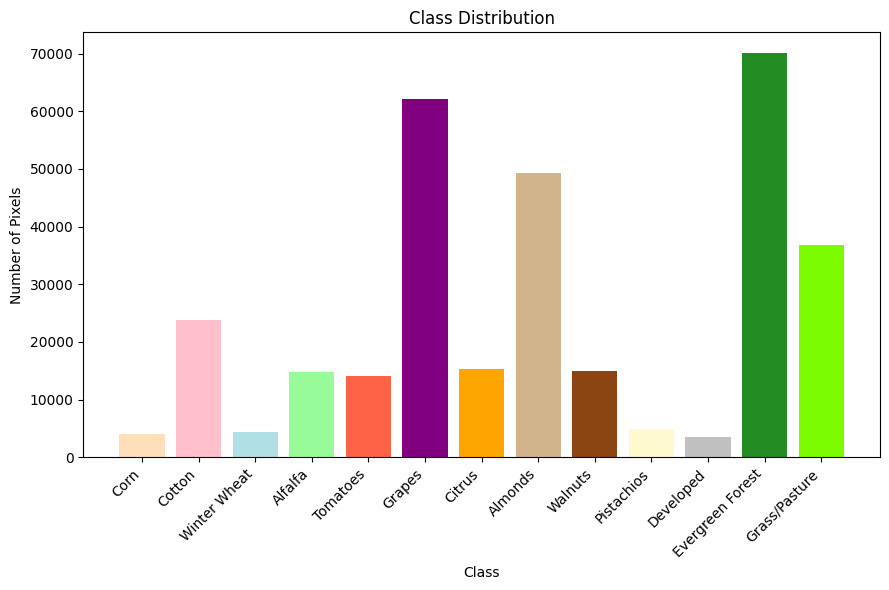

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Class distribution histogram with names

CDL_NAMES = {
    0: "Corn",
    1: "Cotton",
    2: "Winter Wheat",
    3: "Alfalfa",
    4: "Tomatoes",
    5: "Grapes",
    6: "Citrus",
    7: "Almonds",
    8: "Walnuts",
    9: "Pistachios",
    10: "Developed",
    11: "Evergreen Forest",
    12: "Grass/Pasture"
}

unique, counts = np.unique(terrain_map, return_counts=True)

# Getting class names and colors
class_names = [CDL_NAMES[i] for i in unique]
colors = [np.array(CDL_COLORS[i])/255 for i in unique]

plt.figure(figsize=(9, 6))
plt.bar(class_names, counts, color=colors)
plt.xticks(rotation=45, ha='right')  # Label Rotation for readability
plt.xlabel("Class")
plt.ylabel("Number of Pixels")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()
